# Image Signal Processor (ISP)

### Background
An ISP is a processing block that converts raw sensor images into a colour array. There is a surprising amount of image processing that occurs between image capture and output colour images.

You will be provided with samples of binary files containing raw sensor images (details of how to read these image files will be provided). The task is then to convert this raw data into a colour image.

The following processing will be done:
- Read in the image
- Demosaic (convert raw to RGB)
- Apply Colour Correction Matrix (matrix will be provided)
- Apply Denoise (e.g. bilateral filter)
- Apply Edge Enhancement (e.g. unsharp mask)
- Apply Contrast Enhancement (e.g. CLAHE)
- Save result to an output file

In [149]:
# Useful libraries
%matplotlib inline
import os
import os.path as op

import numpy as np
import cv2
from skimage import exposure
from skimage import color
from scipy import ndimage
import matplotlib.pylab as plt
from matplotlib import image
from skimage.color import rgb2gray, gray2rgb

## Read in the raw image file
A raw image file which is an image of a photographic test target. The pixel data is stored as unsigned integers, 8 bits per pixel.
The general process is to read in the binary information, then reshape the array into the image dimensions (in this case, 4096*2160 pixels)


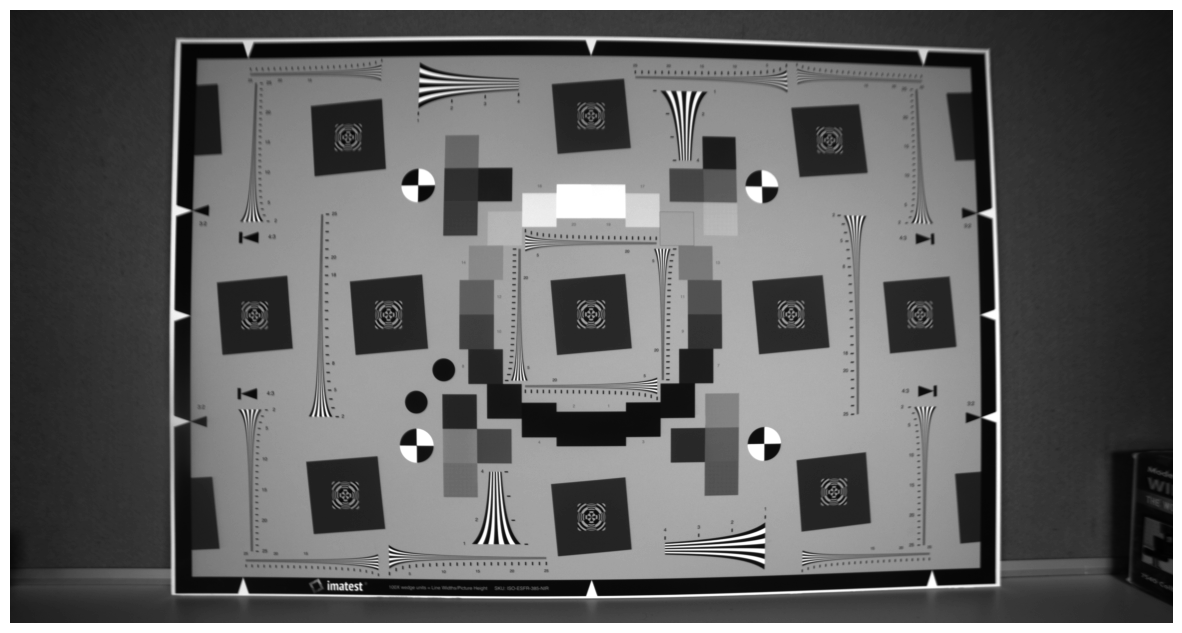

In [150]:
# Read in the file

# Raw file details:
# width - 4096
# height - 2160
# bit depth - 8
# Bayer pattern - rggb

bayer_width = 4096
bayer_height = 2160

raw_path = 'images/chart.raw'

bayer = np.fromfile(raw_path, dtype='uint8', sep='')

bayer = bayer.reshape((bayer_height, bayer_width))

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(bayer,cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

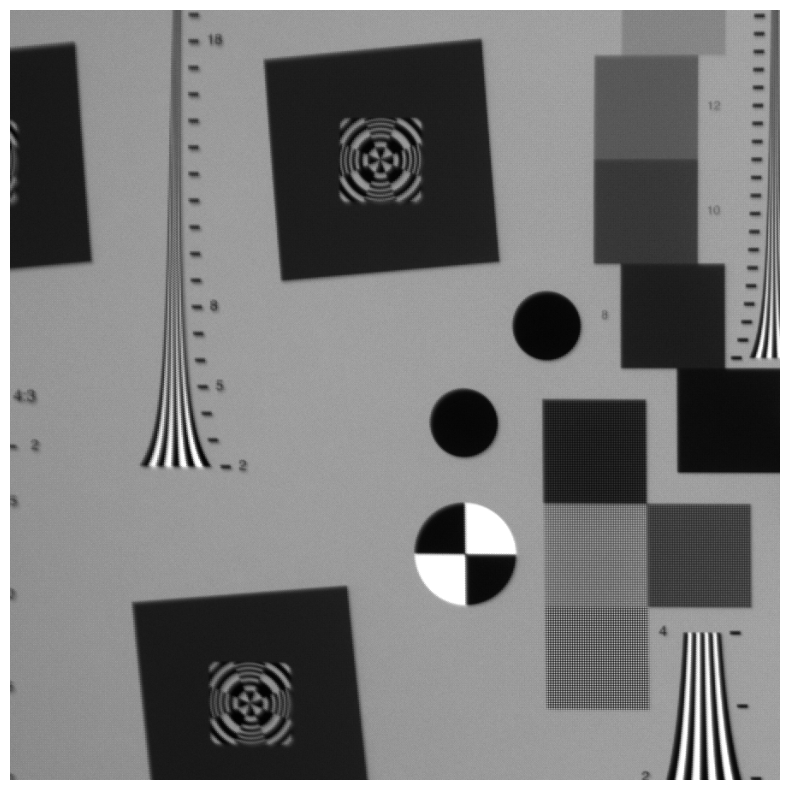

In [151]:
# crop and show a small area, to show the Bayer raw pattern

bayer_crop = bayer[900:1800,900:1800] 

# plot the resulting raw file inline
plt.figure(figsize=(10,10))
plt.imshow(bayer_crop)
plt.axis('off')
plt.show()

## Demosaic the image
The demosaic process converts raw pixel data into RGB image data. Each raw sensor pixel contains only one colour. Part of the demosaic process is to use interpolation to generate the missing colours for each pixel (i.e. a red pixel will get green and blue pixel information from the neighbouring pixels

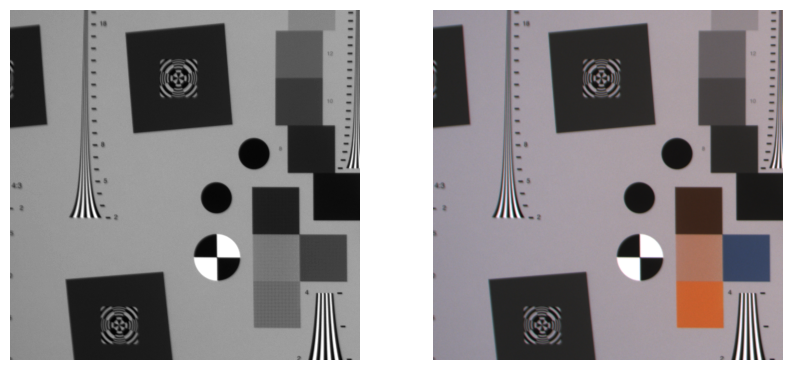

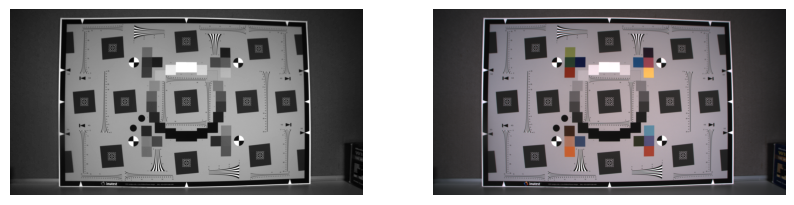

In [152]:
# Demosaic the image (i.e. covert from raw image to RGB)
bgr_image_crop = cv2.cvtColor(bayer_crop,cv2.COLOR_BayerRG2BGR)
bgr_image_full = cv2.cvtColor(bayer,cv2.COLOR_BayerRG2BGR)
# plot the resulting raw file inline
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(bayer_crop)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(bgr_image_crop)
plt.axis('off')
plt.show()
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(bayer)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(bgr_image_full)
plt.axis('off')
plt.show()

## Apply colour correction

A colour correction matrix is applied to improve colour reproduction accuracy. If you notice, red appears too orange before
correction is applied.

The colour correction matrix (CCM) is calculated during the camera development phase, and varies from camera to camera.

For simplicity, the CCM for this particular camera is provided below:
    
    [[ 1382, -113, -246], [ -484, 1808, -300], [ 102, -860, 1802]]
    
 
 This 3*3 matrix is multiplied by the RGB values for every pixel
 
 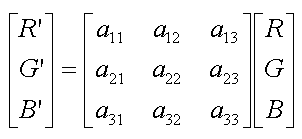
 
 
 
 Note that for embedded applications, floating point numbers are avoided wherever possible. In this example, the base is 1024 (i.e. to convert to floating point, divide the CCM by 1024)
 
 To apply the CCM in this example, the following steps are required:
 - cast the image to np.int32
 - multiply the RGB pixel data by the 3*3 CCM
 - divide by 1024 (note: this can be done by explicit division or right_shift by 10).
 - re-cast the image back to np.uint8
    

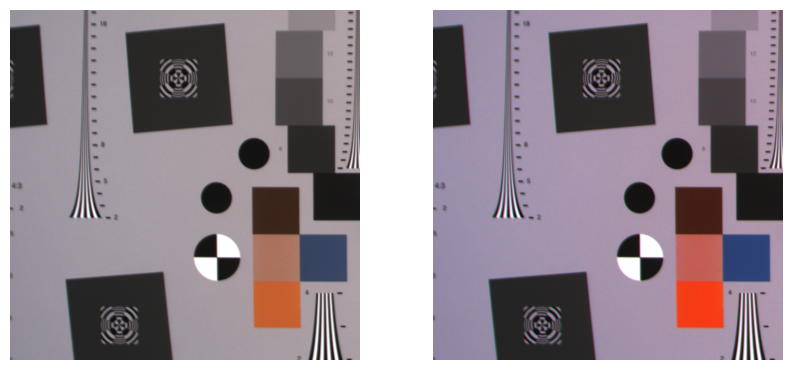

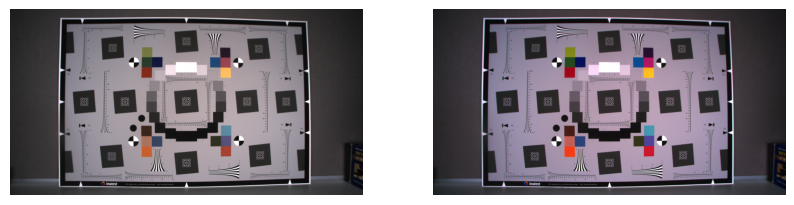

In [153]:
# apply colour correction matrix
# note: to avoid clipping, we have to temporarily cast our image data to int32, and then return to 8 bit
# hint - cast the ccm array and image as np.int32
# multiply the image by the ccm matrix, and then use np.right_shift to scale the image down to the 8 bit range again
# use the np.clip function to ensure the data range is within 0 and 255
bgr_image_int32_crop = bgr_image_crop.astype(np.int32)
bgr_image_int32_full = bgr_image_full.astype(np.int32)
ccm = np.array([[ 1382, -113, -246], [ -484, 1808, -300], [ 102, -860, 1802]],dtype=np.int32).T
corrected_image_crop = np.dot(bgr_image_int32_crop, ccm)
corrected_image_crop = np.right_shift(corrected_image_crop, 10)
corrected_image_crop = np.clip(corrected_image_crop, 0, 255)
corrected_image_full = np.dot(bgr_image_int32_full, ccm)
corrected_image_full = np.right_shift(corrected_image_full, 10)
corrected_image_full = np.clip(corrected_image_full, 0, 255)
# plot the resulting raw file inline
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(bgr_image_int32_crop)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(corrected_image_crop)
plt.axis('off')
plt.show()
plt.figure(figsize=(10,10))
plt.subplot(2,2,3)
plt.imshow(bgr_image_int32_full)
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(corrected_image_full)
plt.axis('off')
plt.show()

## Apply gamma correction

Gamma correction is applied using the following formula:

$$
outputImage = ((inputImage / 255)^\gamma) * 255
$$

Typically, $$\gamma=1/2.2$$

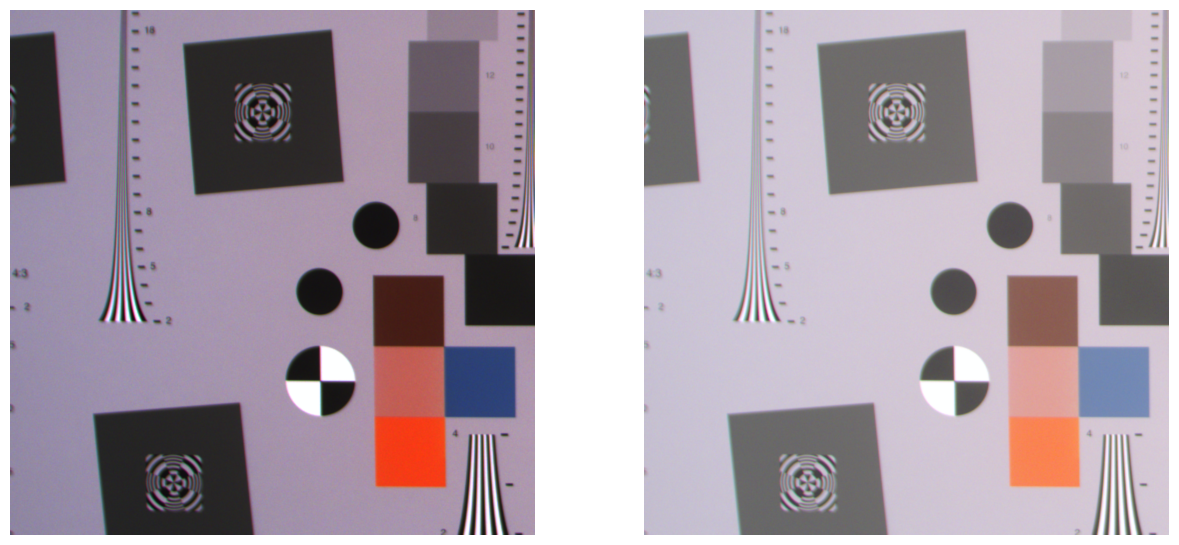

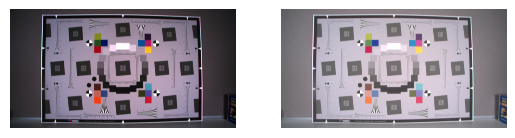

In [154]:
# apply gamma correction
gamma = 1/2.2
gamma_image_crop = np.power(corrected_image_crop / 255.0, gamma) * 255.0
gamma_image_crop = np.clip(gamma_image_crop, 0, 255)
gamma_image_crop = gamma_image_crop.astype(np.uint8)
gamma_image_full = np.power(corrected_image_full / 255.0, gamma) * 255.0
gamma_image_full = np.clip(gamma_image_full, 0, 255)
gamma_image_full = gamma_image_full.astype(np.uint8)
# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(corrected_image_crop)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(gamma_image_crop)
plt.axis('off')
plt.show()
plt.subplot(2,2,3)
plt.imshow(corrected_image_full)
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(gamma_image_full)
plt.axis('off')
plt.show()

## Apply denoise to image
One good option would be openCV's bilateral filter

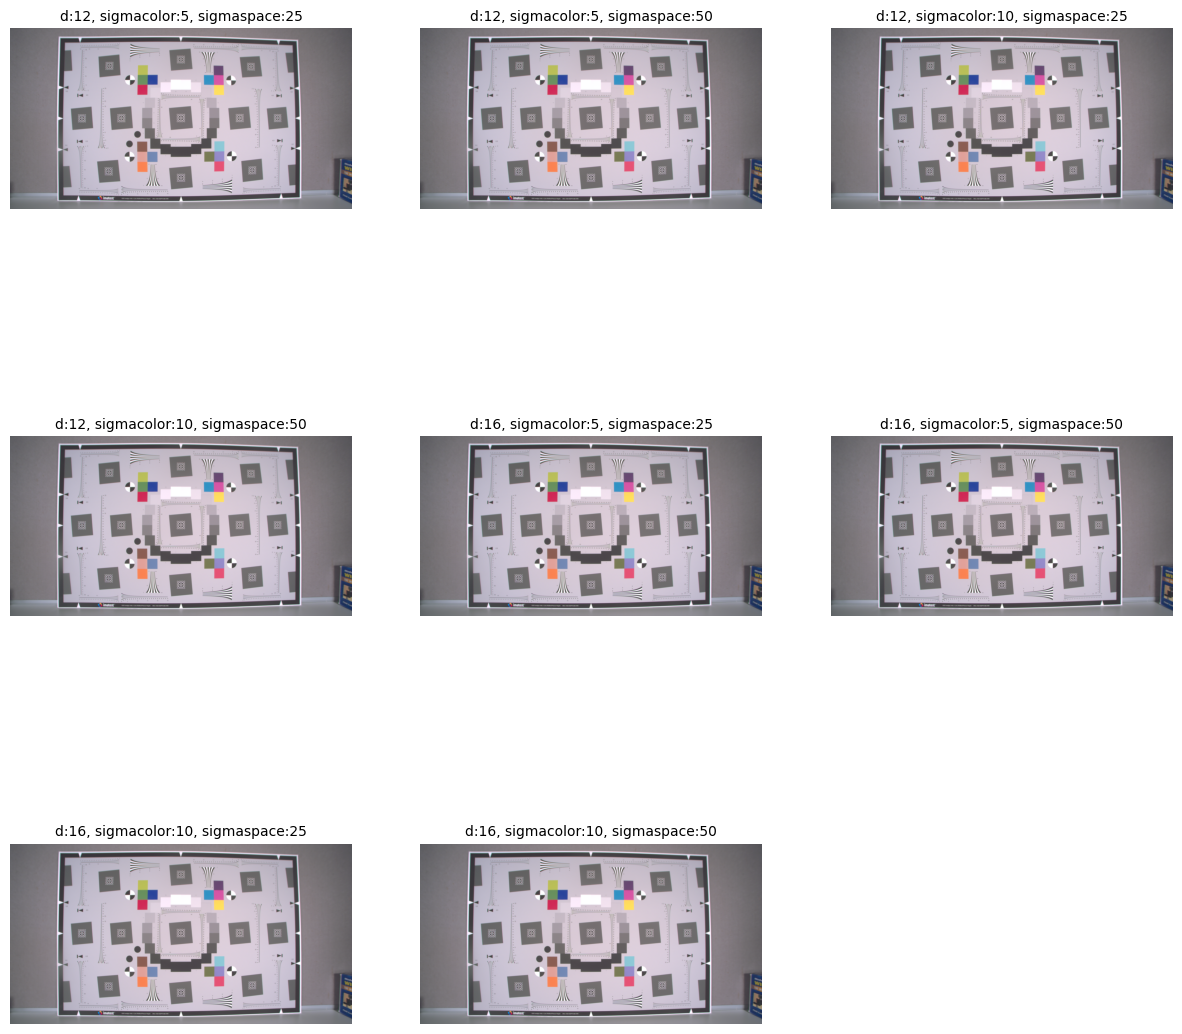

In [155]:
# apply image denoise filtering (bilateral filter)
# hint - use opencv cv2.bilateral filter
# d = neighbour diameter
# sigmacolor = Colour deviation (Smaller value better colour retainment larger value better smoothing)
# Sigmaspace = spacial deviation (smaller value preserves sharpness)
d = [12,16]
sigmacolor = [5,10]
sigmaspace = [25,50]
i = 1
plt.figure(figsize=(15,15))
for dx in d:
    for sigcol in sigmacolor:
        for sigspace in sigmaspace:
            denoised_image = cv2.bilateralFilter(gamma_image_full, d=dx, sigmaColor=sigcol, sigmaSpace=sigspace)
            if dx == 16  and sigcol == 5 and sigspace == 50:
                final_denoised_image = denoised_image
            plt.subplot(3,3,i)
            i += 1
            plt.imshow(denoised_image)
            plt.title(f"d:{dx}, sigmacolor:{sigcol}, sigmaspace:{sigspace}",size = 10)
            plt.axis('off')

## Apply edge enhancement

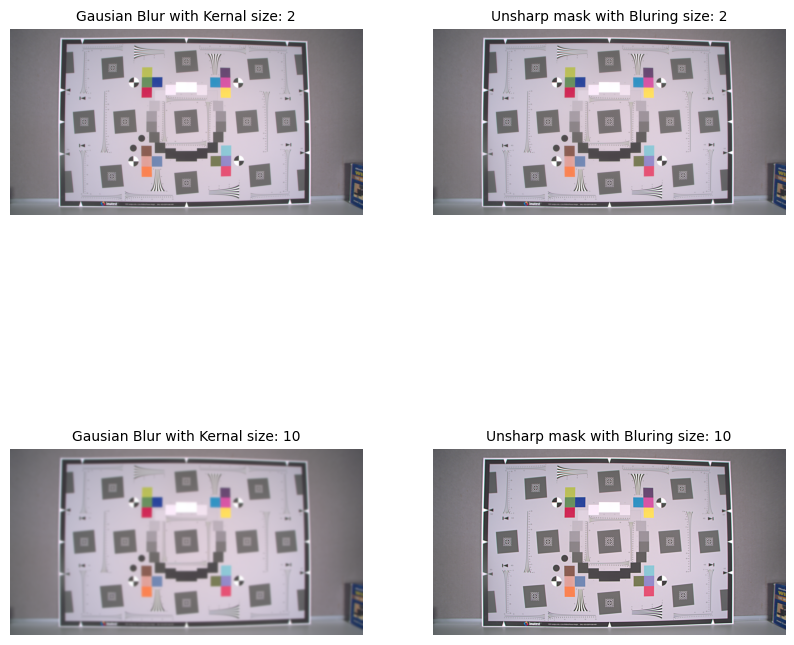

In [156]:
# # apply edge enhancement
# # hint: implement Laplacian or unsharp mask filtering from previous course material.
# # (0,0) means set the kernal for gausian blur automatically based on deviation , 2 - Deviation of gausian kernel
blur_aspect = [2,10]
i = 1
plt.figure(figsize=(10,10))
for blur in blur_aspect:
    # Blurring using Gausian passing blur_aspect
    gaussian_blur = cv2.GaussianBlur(final_denoised_image, (0, 0), blur)
    # Using addWeighted fucntion to multiple original image by 1.5 and attenuation blured image by 0.5
    unsharp_mask  = cv2.addWeighted(final_denoised_image, 1.5, gaussian_blur, -0.5, 0)
    plt.subplot(2,2,i)
    i += 1
    plt.imshow(gaussian_blur)
    plt.title(f"Gausian Blur with Kernal size: {blur}",size = 10)
    plt.axis('off')
    plt.subplot(2,2,i)
    i += 1
    plt.imshow(unsharp_mask)
    plt.title(f"Unsharp mask with Bluring size: {blur}",size = 10)
    plt.axis('off')

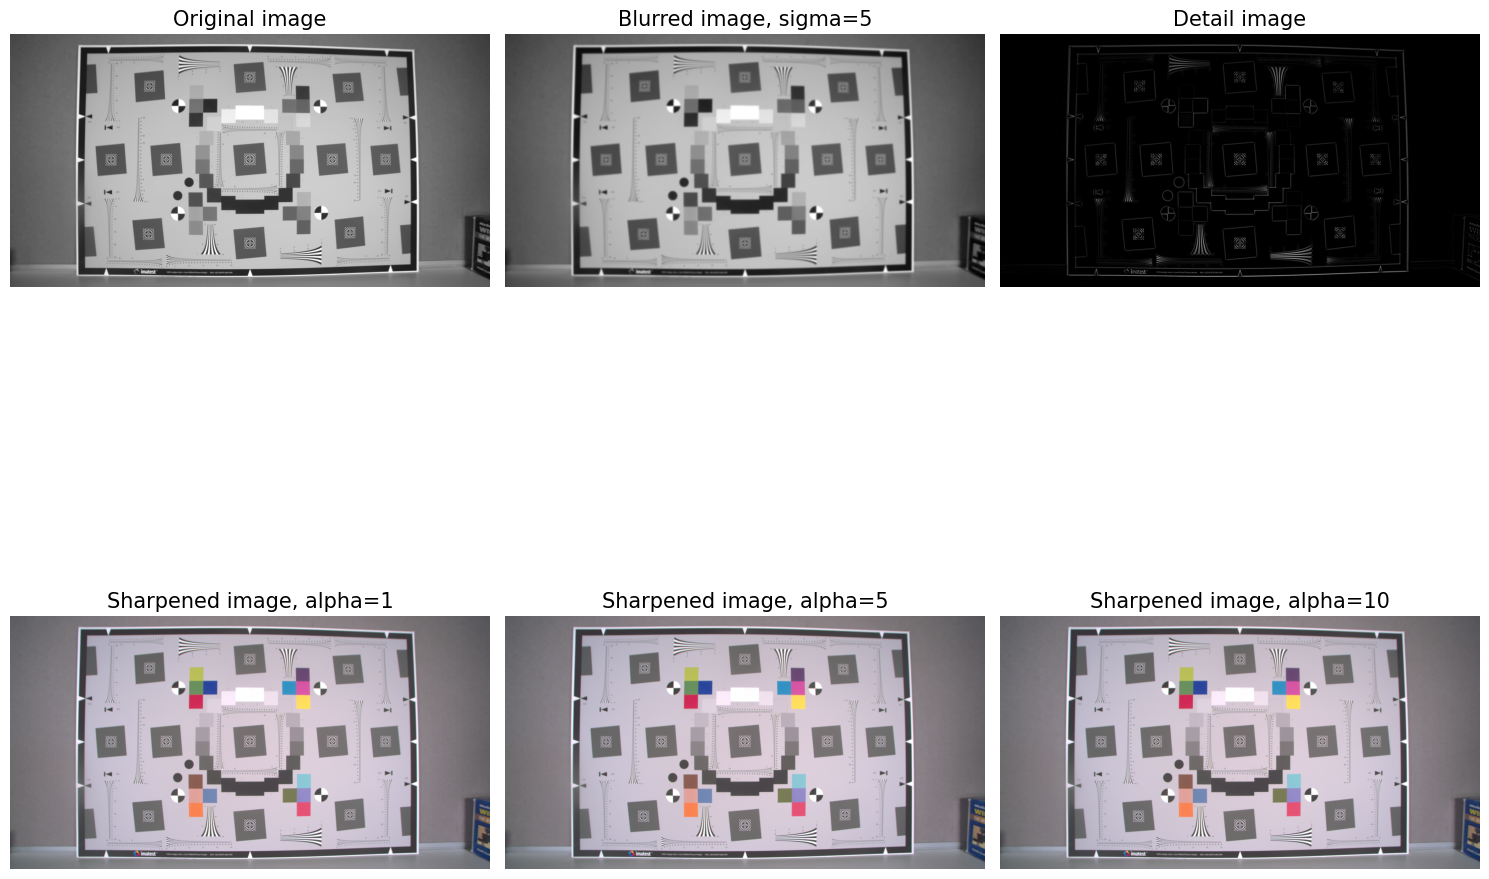

In [157]:
# Unsharp Mask on Gray Image
im = rgb2gray(final_denoised_image)
im_blurred = ndimage.gaussian_filter(im, 5)
im_detail = np.clip(im - im_blurred, 0, 1)
final_im_detail = np.stack([im_detail] * 3, axis=-1)
# plt.gray()
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 15))
axes = axes.ravel()
axes[0].set_title('Original image', size=15), axes[0].imshow(im)
axes[1].set_title('Blurred image, sigma=5', size=15),
axes[1].imshow(im_blurred)
axes[2].set_title('Detail image', size=15), axes[2].imshow(im_detail)
alpha = [1, 5, 10]
for i in range(3):
    # Changing Alpha Values to edit more sharpness for gray image
    im_sharp = np.clip(final_denoised_image + alpha[i]*final_im_detail, 0, 255).astype(np.uint8)
    axes[3+i].imshow(im_sharp), axes[3+i].set_title('Sharpened image, alpha=' + str(alpha[i]), size=15)
    if alpha[i] == 5 : final_sharp = im_sharp
for ax in axes:
    ax.axis('off')
fig.tight_layout()
plt.show()

## Apply contrast enhancement

Finally, apply contrast enhancement to the image. One option would be adaptive histogram equalization, covered earlier in the module (check out the skimage exposure library). And again, vary the parameters to examine the effect on the final image

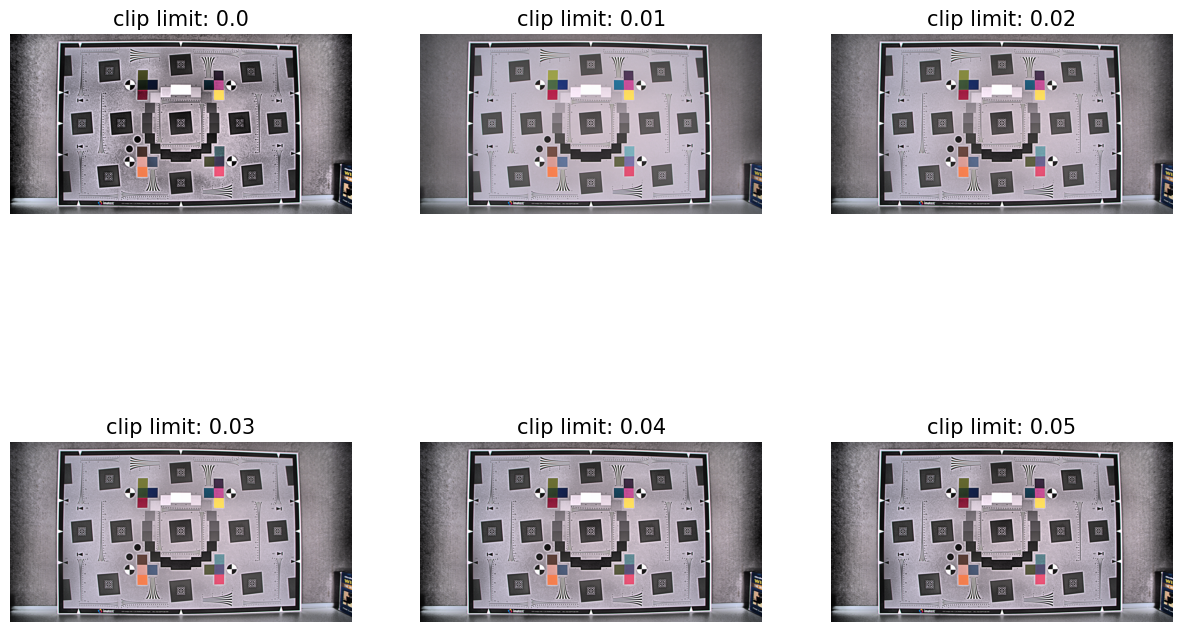

In [158]:
plt.figure(figsize=(15,15))
k = 1
for i in np.arange(0,0.06,0.01):
    enhanced_image = exposure.equalize_adapthist(unsharp_mask, clip_limit=i)
    if i == 0.01 : final_plot_image_rgb = enhanced_image
    # plot the resulting raw file inline
    plt.subplot(3,3,k)
    k += 1
    plt.title(f'clip limit: {i}',size = 15)
    plt.imshow(enhanced_image)
    plt.axis('off')
plt.show()

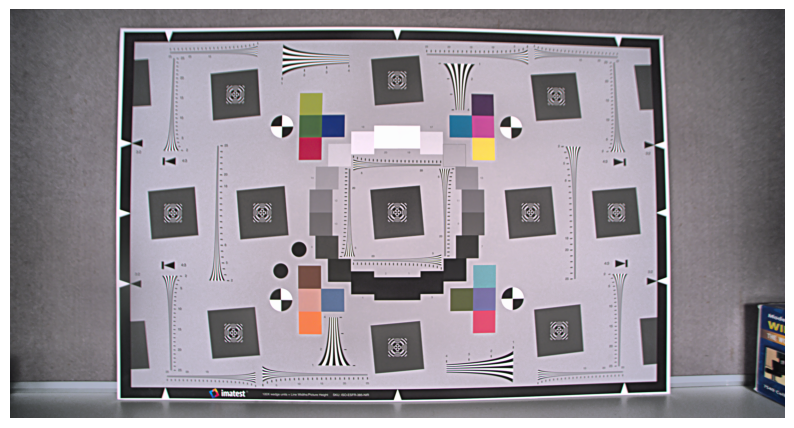

In [159]:
# best RGB Edge enhancement Image
plt.figure(figsize=(10,10))
plt.subplot(1,1,1)
plt.imshow(final_plot_image_rgb)
plt.axis('off')
plt.show();

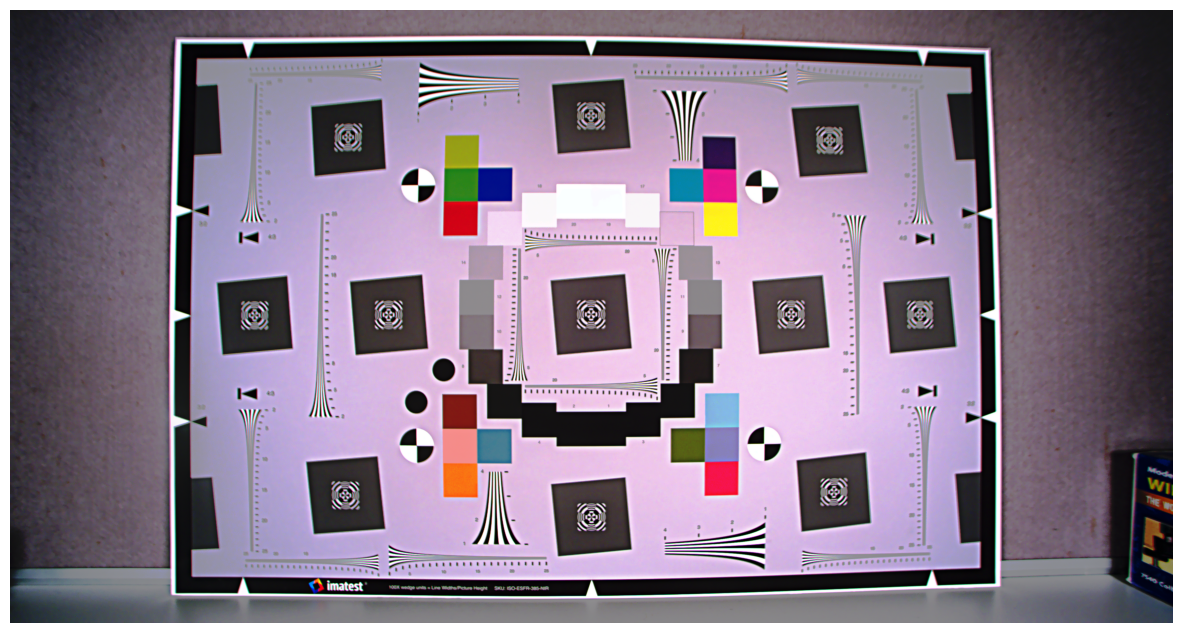

In [160]:
# Using equalize hist to create contrast on RGB image
plt.figure(figsize=(15,15))
equalized_image = exposure.equalize_hist(unsharp_mask)
# plot the resulting raw file inline
plt.subplot(1,1,1)
plt.imshow(equalized_image)
plt.axis('off')
plt.show()

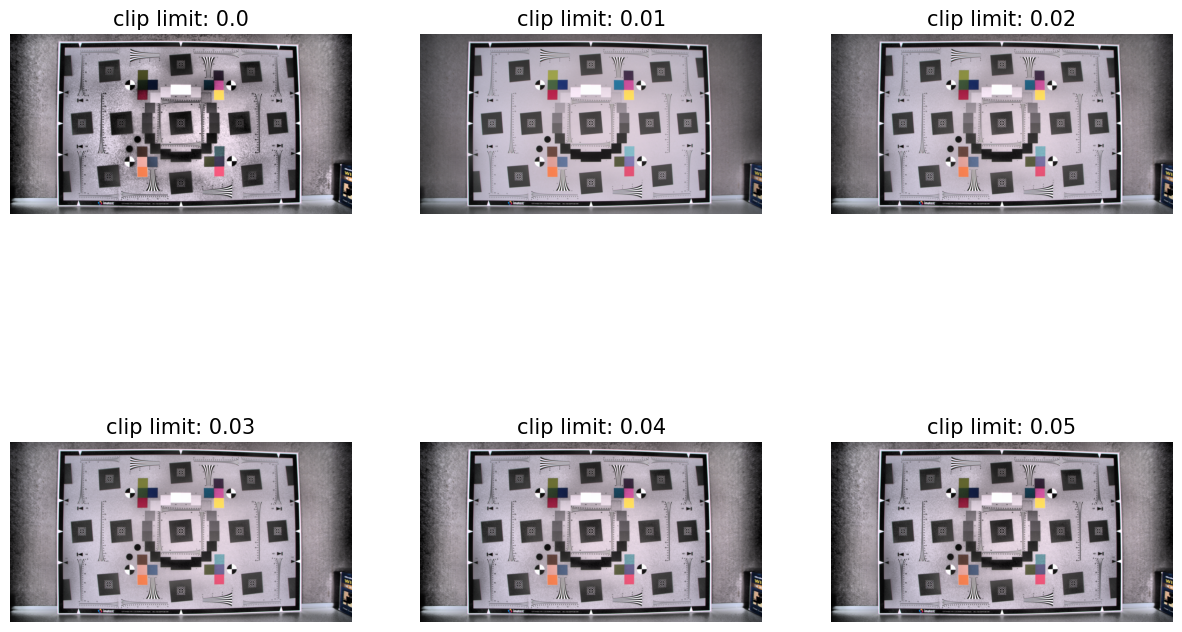

In [161]:
# Using Adaptive Hist on RGB Image Part2
plt.figure(figsize=(15,15))
k = 1
for i in np.arange(0,0.06,0.01):
    enhanced_image = exposure.equalize_adapthist(final_sharp, clip_limit=i)
    if i == 0.01 : final_plot_image_rgb2 = enhanced_image
    # plot the resulting raw file inline
    plt.subplot(3,3,k)
    k += 1
    plt.title(f'clip limit: {i}',size = 15)
    plt.imshow(enhanced_image)
    plt.axis('off')
plt.show()

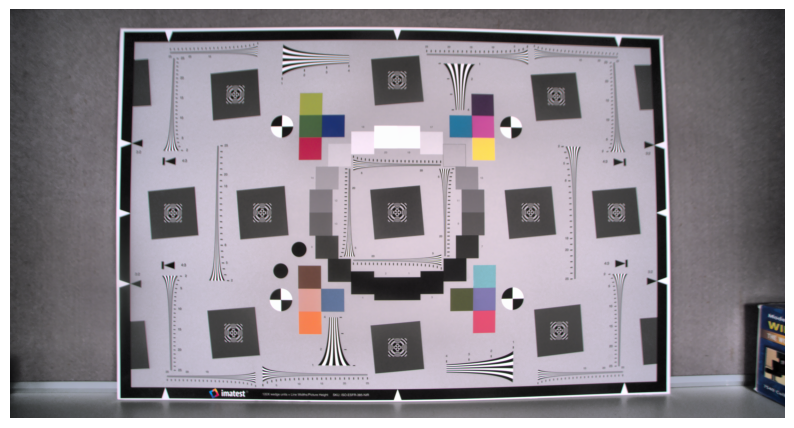

In [162]:
plt.figure(figsize=(10,10))
plt.subplot(1,1,1)
plt.imshow(final_plot_image_rgb2)
plt.axis('off')
plt.show();

In [163]:
plt.imsave('Your_Desired_File_name.png', final_plot_image_rgb)

In [164]:
plt.imsave('Your_Desired_File_name.png', final_plot_image_rgb2)

In [165]:
plt.imsave('Your_Desired_File_name.png', equalized_image)